# SCROLL TO THE BOTTOM FOR TRANSFER LEARNING

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving tracks.csv to tracks.csv


## Import Libraries

In [ ]:
!python3 -m pip install "dask[complete]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!python3 -m pip install dask-ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 4.5 MB/s eta 0:00:00


In [ ]:
# import relevant libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import f1_score

In [ ]:
np.__version__

'1.22.4'

## Data Cleaning for Spotify Dataset

In [ ]:
# import relevant libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import f1_score

# import the dataset
spotify_tracks = pd.read_csv('/content/tracks.csv')

# drop duplicates with the same name and artist
spotify_tracks = spotify_tracks.drop_duplicates(
  subset = ['name', 'artists'],
  keep = 'last').reset_index(drop = True)

# convert release_time to appropriate time date format
spotify_tracks['release_date']= pd.to_datetime(spotify_tracks['release_date'], format='%Y-%m-%d')

# remove songs older than 1990
spotify_tracks = spotify_tracks[spotify_tracks['release_date'].dt.year >= 1990]

# change duration from ms to minutes
spotify_tracks['duration_ms'] = spotify_tracks['duration_ms']/60000

# rearrange columns"
spotify_tracks = spotify_tracks[['id',
        'name',
        'artists',
 'id_artists',
 'release_date',
 'duration_ms',
 'explicit',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'time_signature',
 'popularity',
]]

# reset index
spotify_tracks = spotify_tracks.reset_index(drop=True)

<ipython-input-6-df3d4522bd4c>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spotify_tracks['duration_ms'] = spotify_tracks['duration_ms']/60000


## Spotify EDA

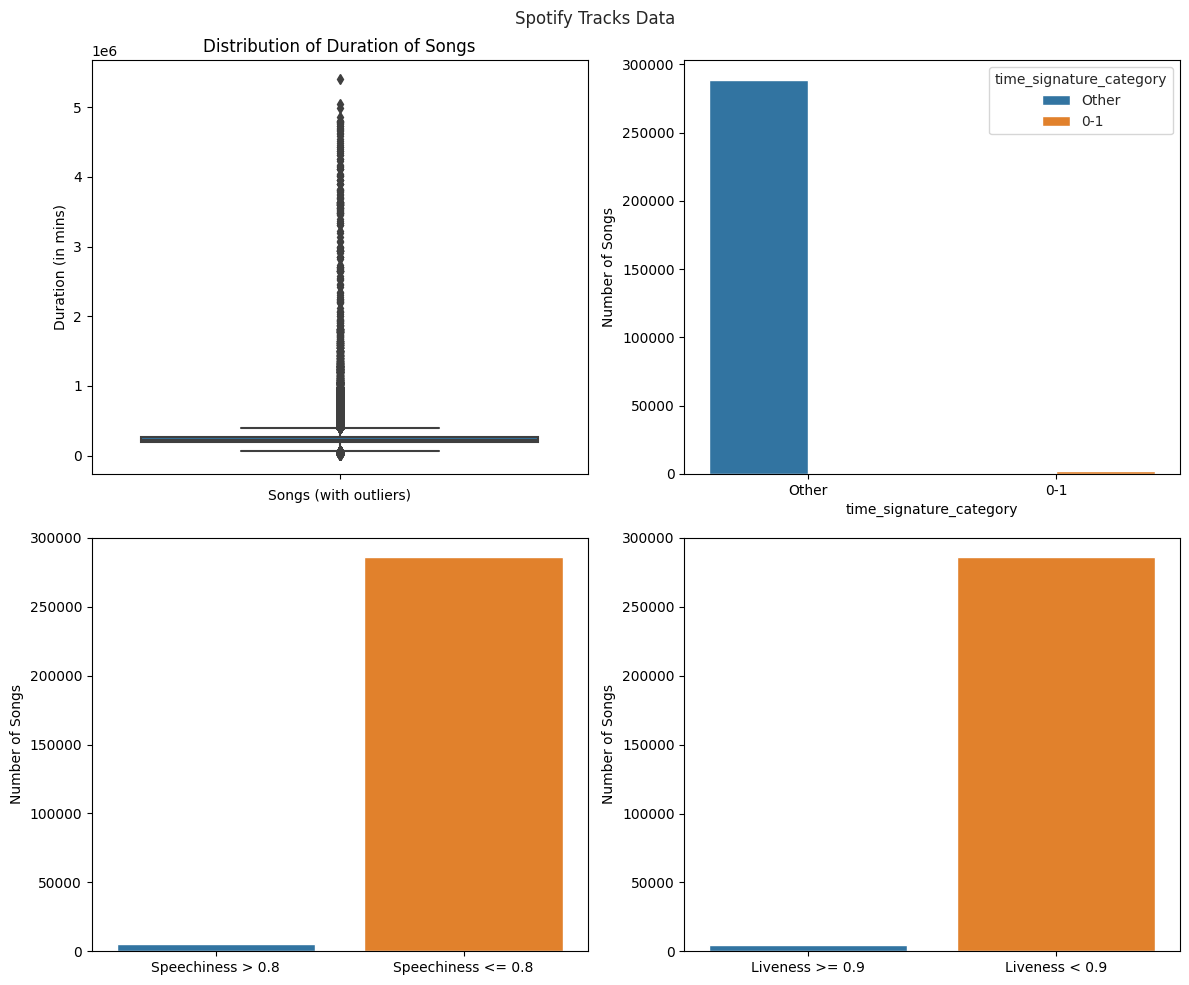

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1
sns.set_style('whitegrid')
sns.boxplot(y=spotify_tracks['duration_ms'] * 60000, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Duration of Songs')
axes[0, 0].set_ylabel('Duration (in mins)')
axes[0, 0].set_xlabel('Songs (with outliers)')

# Plot 2
subset = spotify_tracks.copy()
subset['time_signature_category'] = subset['time_signature'].apply(lambda x: '0-1' if x in [0, 1] else 'Other')
sns.countplot(data=subset, x='time_signature_category', hue='time_signature_category', ax=axes[0, 1])
axes[0, 1].set_ylabel('Number of Songs')

# Plot 3
subset = spotify_tracks[spotify_tracks['speechiness'] > 0.8]
group_counts = [len(subset), len(spotify_tracks) - len(subset)]
x_labels = ['Speechiness > 0.8', 'Speechiness <= 0.8']
sns.barplot(x=x_labels, y=group_counts, ax=axes[1, 0])
axes[1, 0].set_ylabel('Number of Songs')

# Plot 4
subset = spotify_tracks[spotify_tracks['liveness'] >= 0.9]
group_counts = [len(subset), len(spotify_tracks) - len(subset)]
x_labels = ['Liveness >= 0.9', 'Liveness < 0.9']
sns.barplot(x=x_labels, y=group_counts, ax=axes[1, 1])
axes[1, 1].set_ylabel('Number of Songs')

# Set overall title
fig.suptitle('Spotify Tracks Data')

# Adjust spacing between plots
plt.tight_layout()

# Display the subplots
plt.show()

In [ ]:
# identify IQR for duration and remove outliers
Q1 = np.percentile(spotify_tracks['duration_ms'], 25,
                   method = 'midpoint')
Q3 = np.percentile(spotify_tracks['duration_ms'], 75,
                   method = 'midpoint')

IQR = Q3 - Q1
upper = Q3 + 1.5*IQR
lower = Q1 - 1.5*IQR
upper_array=np.where(spotify_tracks['duration_ms']>=upper)
lower_array=np.where(spotify_tracks['duration_ms']<=lower)

spotify_tracks.drop(upper_array[0],inplace=True)
spotify_tracks.drop(lower_array[0],inplace=True)

# remove songs with time signature = 0, 1
spotify_tracks = spotify_tracks[(spotify_tracks['time_signature'] != 0) & 
                                (spotify_tracks['time_signature'] !=1)]

# remove songs with high speechiness like talk shows, audio books, poetry
spotify_tracks = spotify_tracks[spotify_tracks['speechiness']<0.8]

# remove songs with live audiences
spotify_tracks = spotify_tracks[spotify_tracks['liveness']<0.9]

### Spotify Data by Year

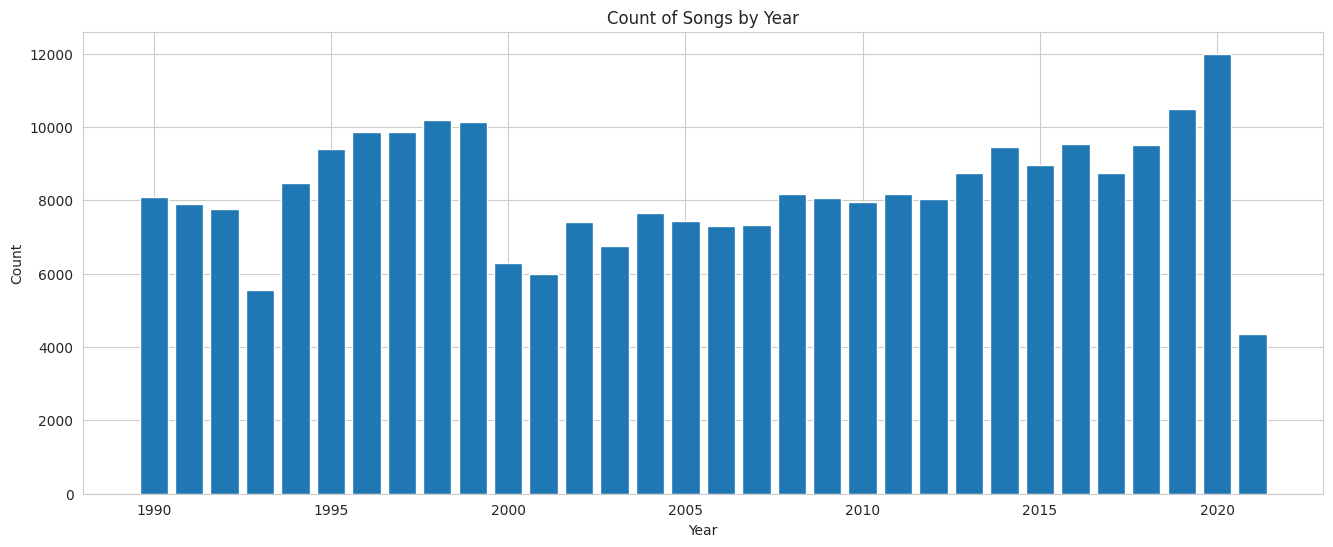

In [ ]:
counts = spotify_tracks['release_date'].dt.year.value_counts().sort_index()

fig, ax = plt.subplots(figsize=(len(counts) * 0.5, 6))
ax.bar(counts.index, counts.values)

# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.set_title('Count of Songs by Year')

# Display the plot
plt.show()

In [ ]:
# drop the artist_id, since we have the artist name
spotify_tracks.drop(columns = ['id', 'id_artists'], inplace=True)

# drop all null values
spotify_tracks = spotify_tracks.dropna()

# separate releasedate to month and year and drop releasedate
spotify_tracks['month'] = pd.DatetimeIndex(spotify_tracks['release_date']).month
spotify_tracks['year'] = pd.DatetimeIndex(spotify_tracks['release_date']).year
spotify_tracks.drop(columns = ['release_date'], axis = 1, inplace=True)

<ipython-input-10-14722c412e3d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spotify_tracks['month'] = pd.DatetimeIndex(spotify_tracks['release_date']).month
<ipython-input-10-14722c412e3d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spotify_tracks['year'] = pd.DatetimeIndex(spotify_tracks['release_date']).year


### Correlation between Different Attributes

<ipython-input-11-c98f3ae8d2bc>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(spotify_tracks.corr(), annot=True, fmt='.2f')


<Axes: >

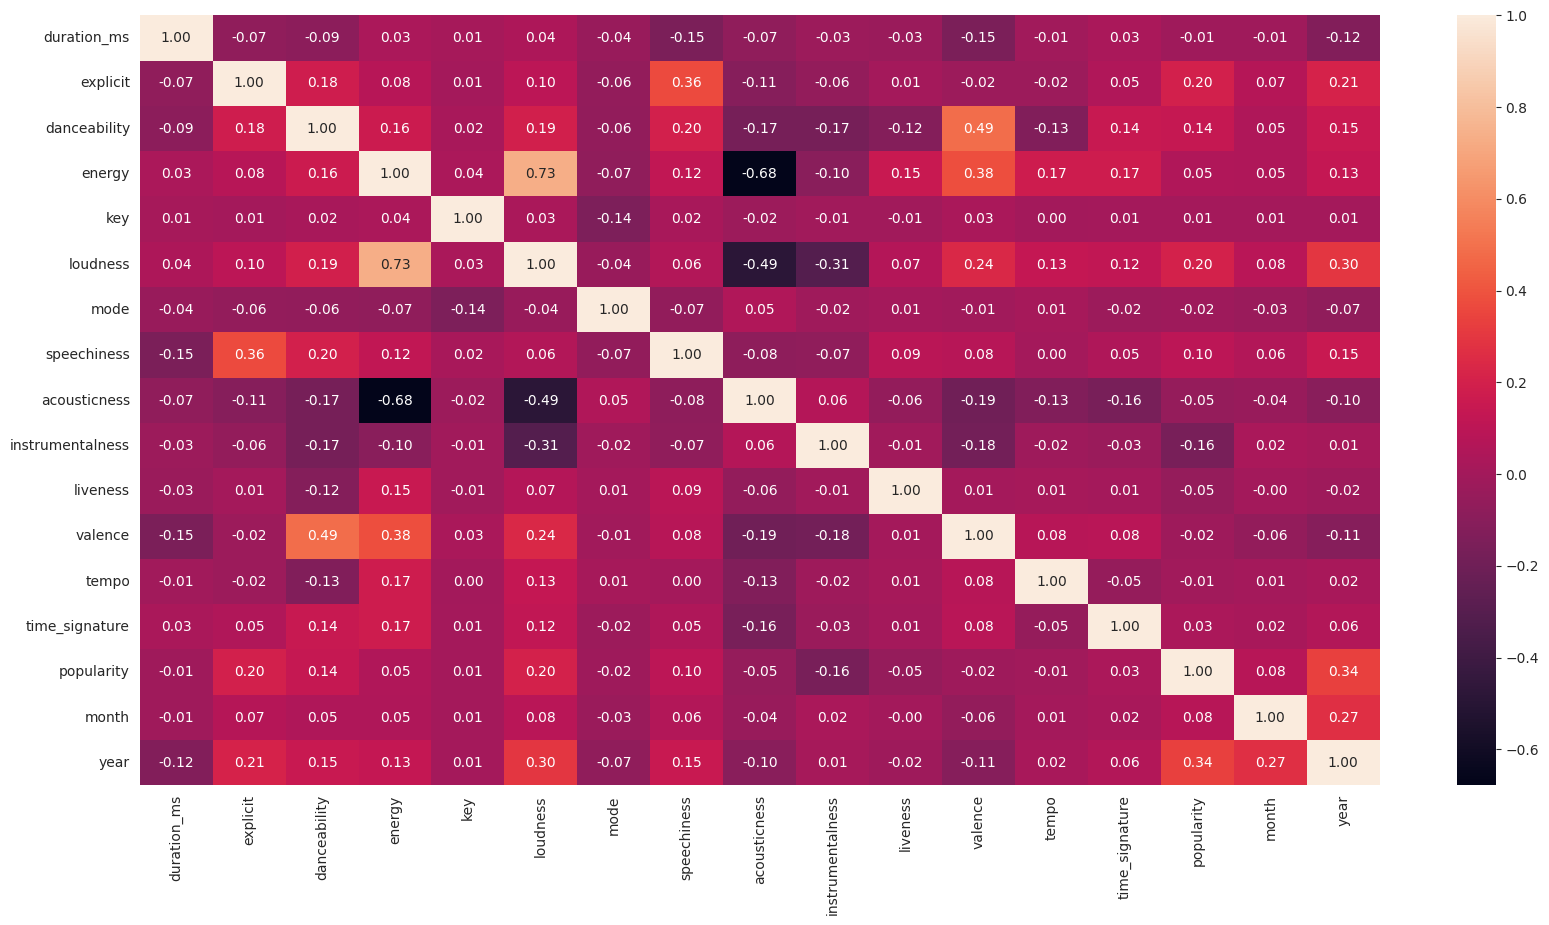

In [ ]:
# With annotation
plt.figure(figsize=(20,10))
# Displaying graph
sns.heatmap(spotify_tracks.corr(), annot=True, fmt='.2f')

In [ ]:
# it seems like energy/loudness, as well as loudness/acousticness are correlated, and energy/acousticness; decide to remove acousticness and loudness
spotify_tracks.drop(columns = ['loudness', 'acousticness'], inplace=True)

# ensure that song name and artist name is a string
spotify_tracks['name'] = spotify_tracks['name'].astype(str)
spotify_tracks['artists'] = spotify_tracks['artists'].astype(str)

# remove all non alphanumeric characters in song name and artists
spotify_tracks['name'] = spotify_tracks['name'].replace(r'[^A-Za-z0-9\s]+', '', regex=True)
spotify_tracks['artists'] = spotify_tracks['artists'].replace(r'[^A-Za-z0-9\s]+', '', regex=True)

# remove extra spaces in song name and artists
spotify_tracks['name'] = spotify_tracks['name'].replace(r'\s\s+', ' ', regex=True)
spotify_tracks['artists'] = spotify_tracks['artists'].replace(r'\s\s+', ' ', regex=True)

# remove all special characters, including punctuation
spotify_tracks['name'] = spotify_tracks['name'].replace(r'[^\w\s]|_', '', regex=True)
spotify_tracks['artists'] = spotify_tracks['artists'].replace(r'[^\w\s]|_', '', regex=True)

# make all characters in song name and artist lowercase
spotify_tracks['name'] = spotify_tracks.name.apply(lambda x: x.lower())
spotify_tracks['artists'] = spotify_tracks.artists.apply(lambda x: x.lower())

# length of spotify_tracks
len(spotify_tracks)

265669

### Effect of Different Attributes on Popularity

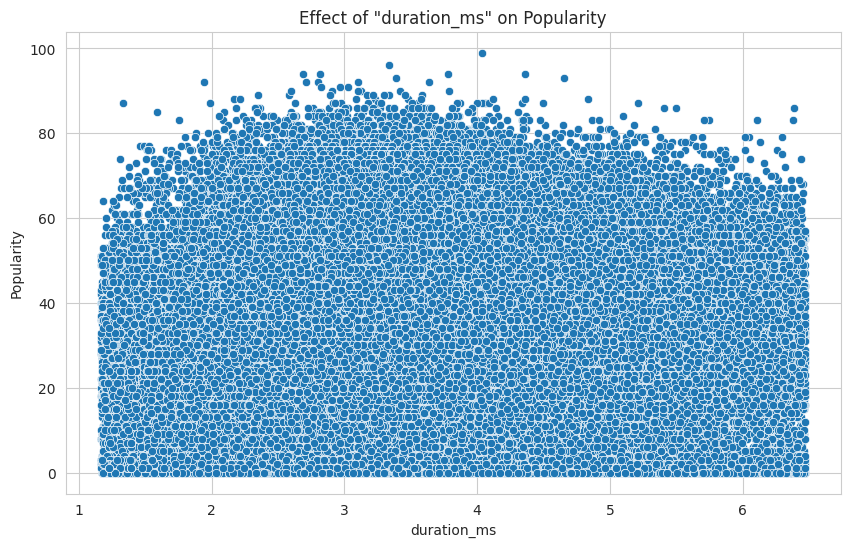

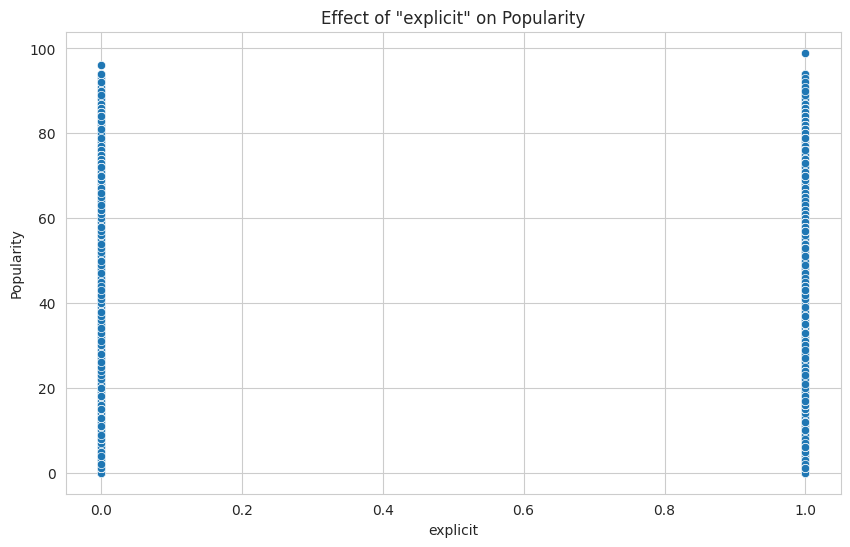

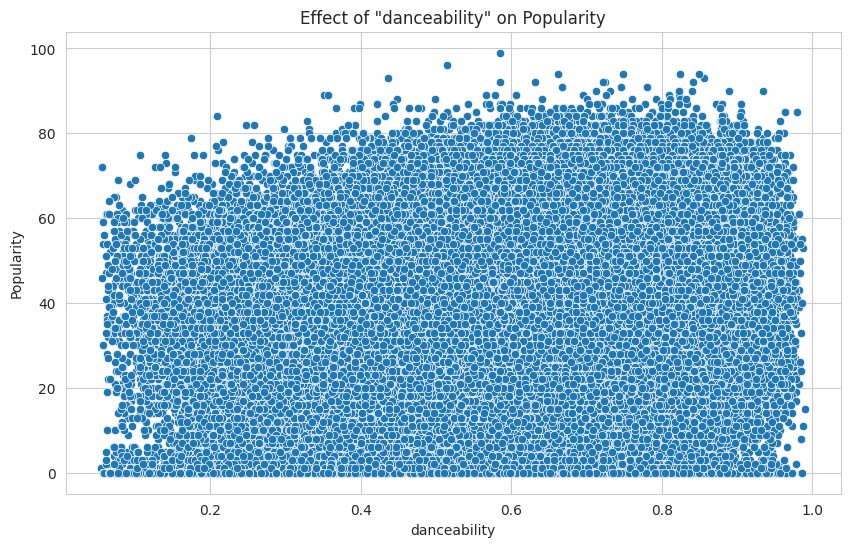

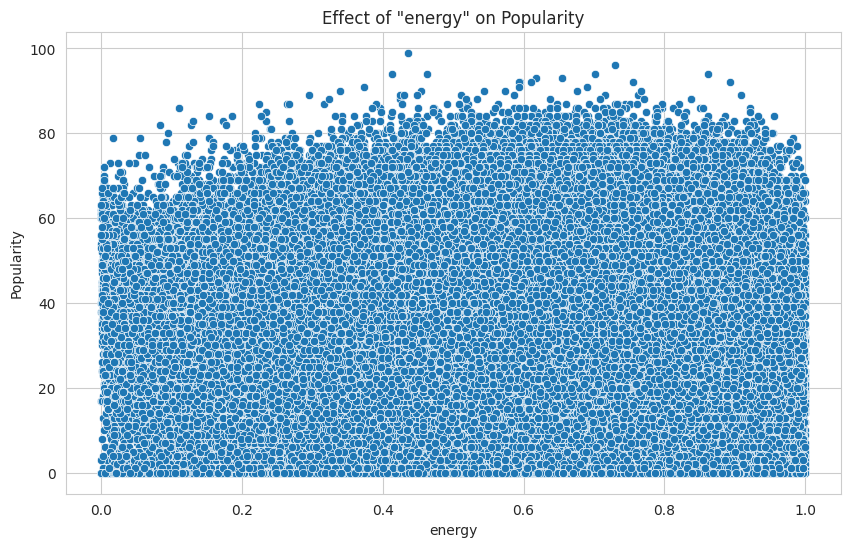

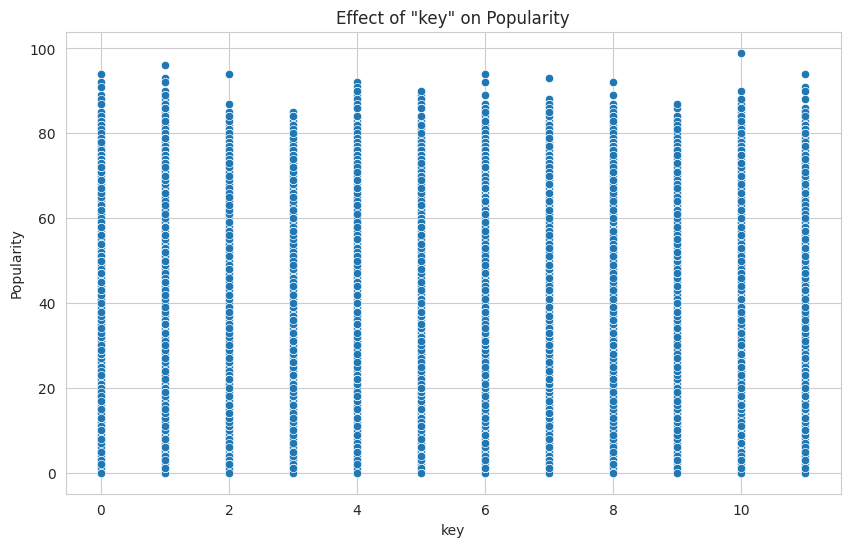

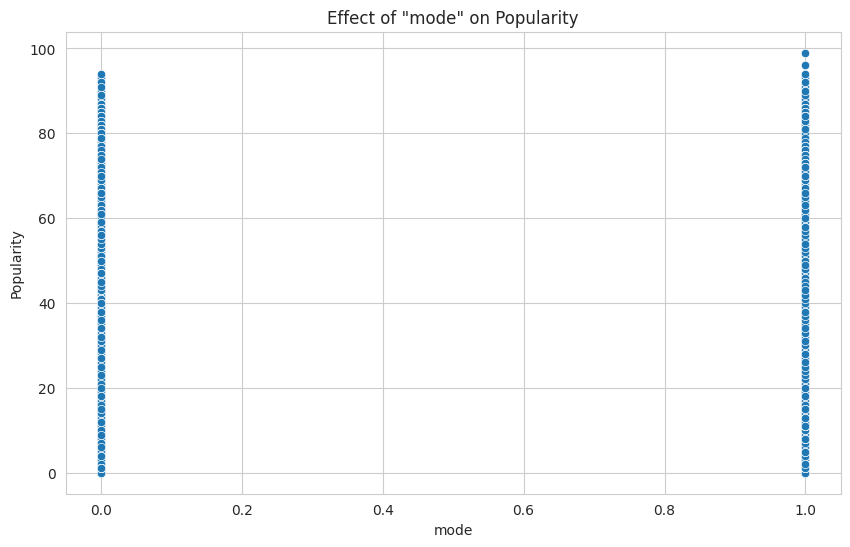

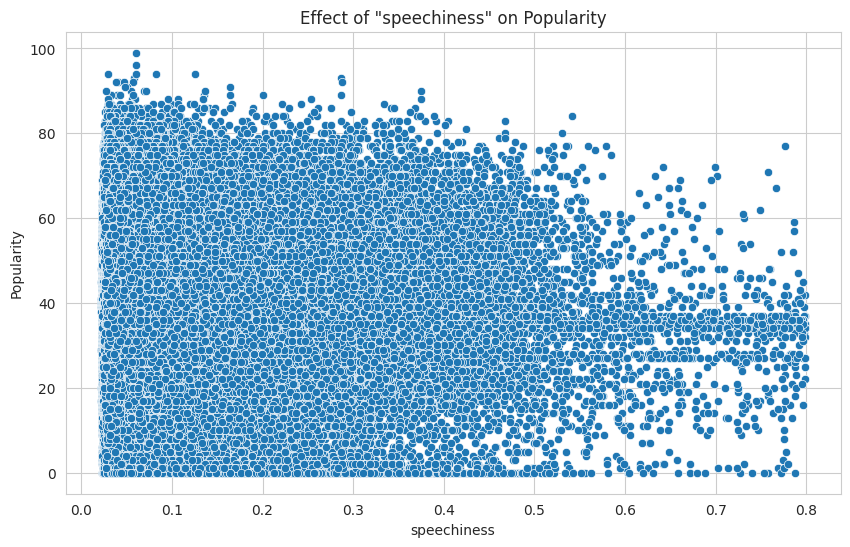

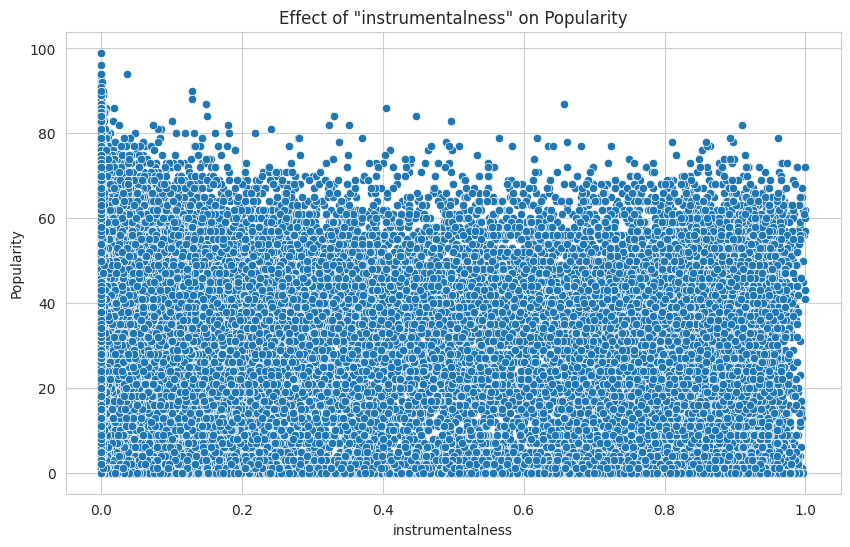

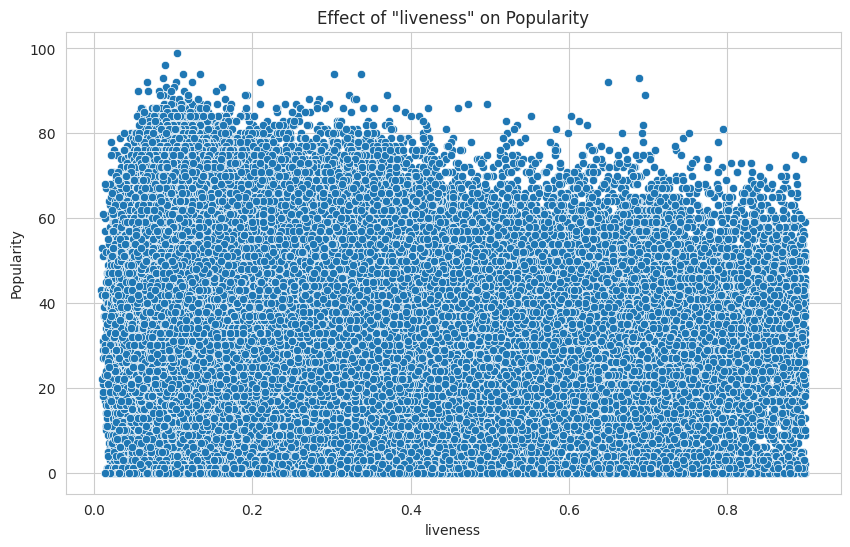

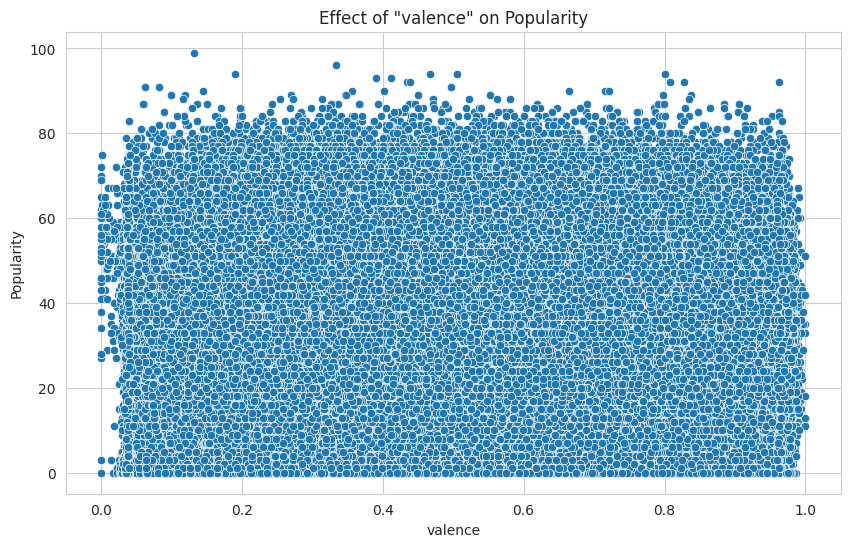

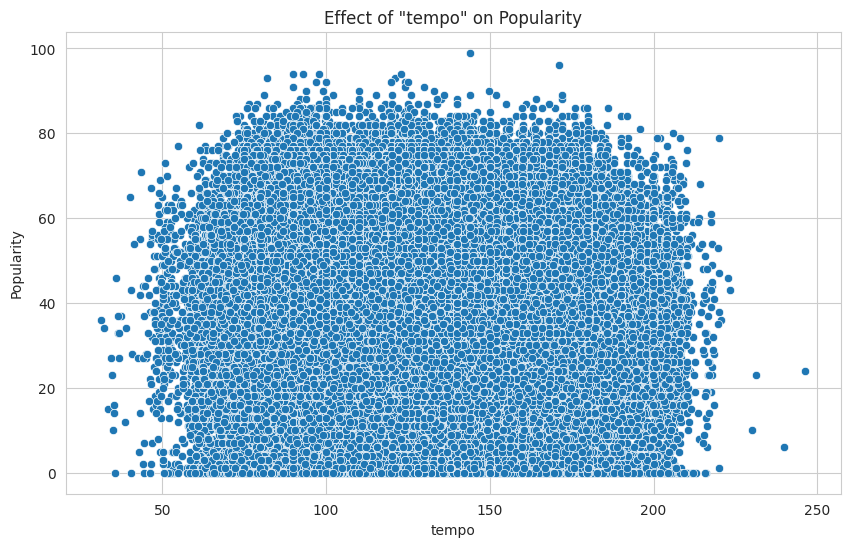

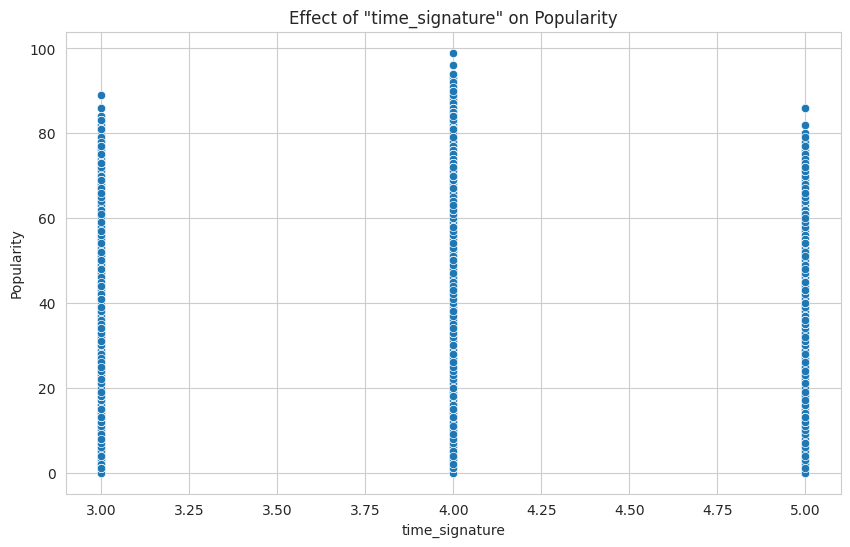

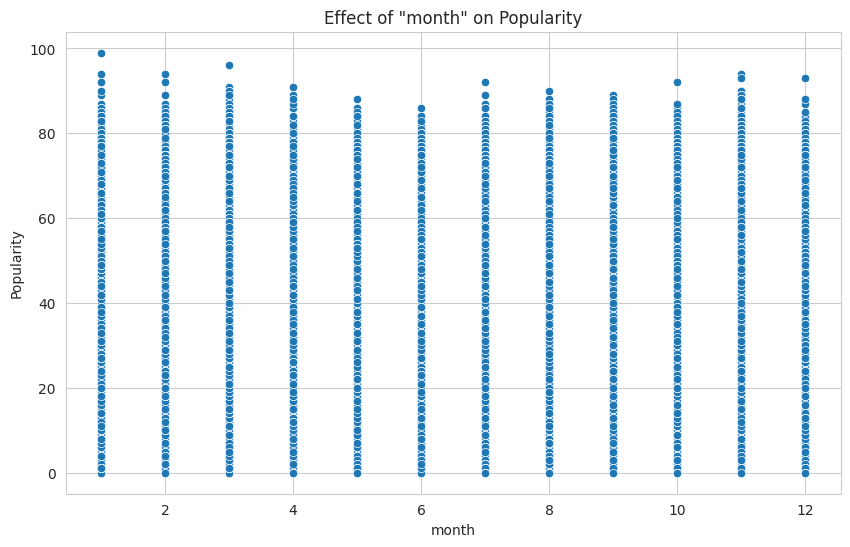

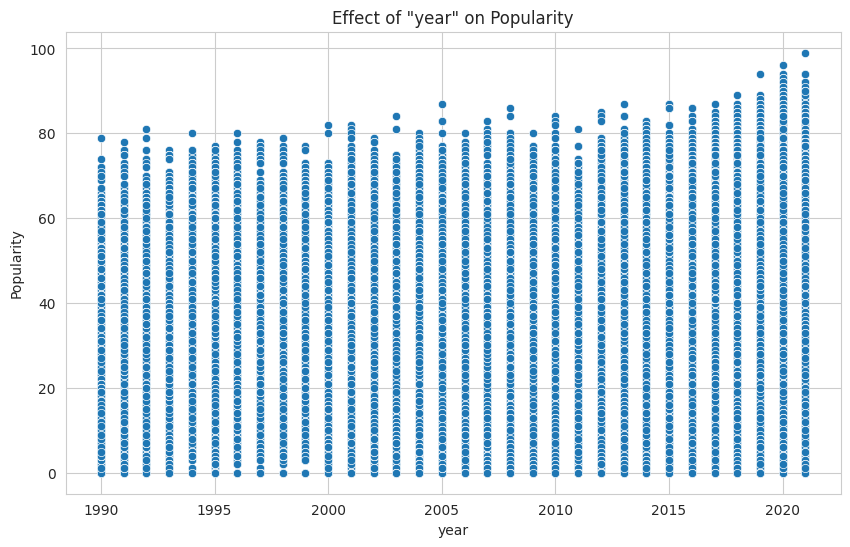

In [ ]:
attributes = ['duration_ms', 'explicit', 'danceability', 'energy', 'key', 'mode',
              'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo',
              'time_signature', 'month', 'year']

# Plot the effect of each attribute on 'popularity'

for attribute in attributes:
  if spotify_tracks[attribute].dtype == 'object':
      # For categorical attributes, use a bar plot
      plt.figure(figsize=(10, 6))
      sns.barplot(x=spotify_tracks[attribute], y=spotify_tracks['popularity'])
      plt.xlabel(attribute)
      plt.ylabel('Popularity')
      plt.title(f'Effect of "{attribute}" on Popularity')
      plt.xticks(rotation=45)
      plt.show()
  else:
      # For numerical attributes, use a scatter plot
      plt.figure(figsize=(10, 6))
      sns.scatterplot(x=spotify_tracks[attribute], y=spotify_tracks['popularity'])
      plt.xlabel(attribute)
      plt.ylabel('Popularity')
      plt.title(f'Effect of "{attribute}" on Popularity')
      plt.show()

## Data Cleaning for Billboard Dataset

In [ ]:
# import the dataset
billboard_tracks = pd.read_csv('/content/charts.csv')

# convert release_time to appropriate time date format
billboard_tracks['release_date']= pd.to_datetime(billboard_tracks['date'], format='%Y-%m-%d')

# remove songs older than 1990
billboard_tracks = billboard_tracks[billboard_tracks['release_date'].dt.year >= 1990]

### Top Songs

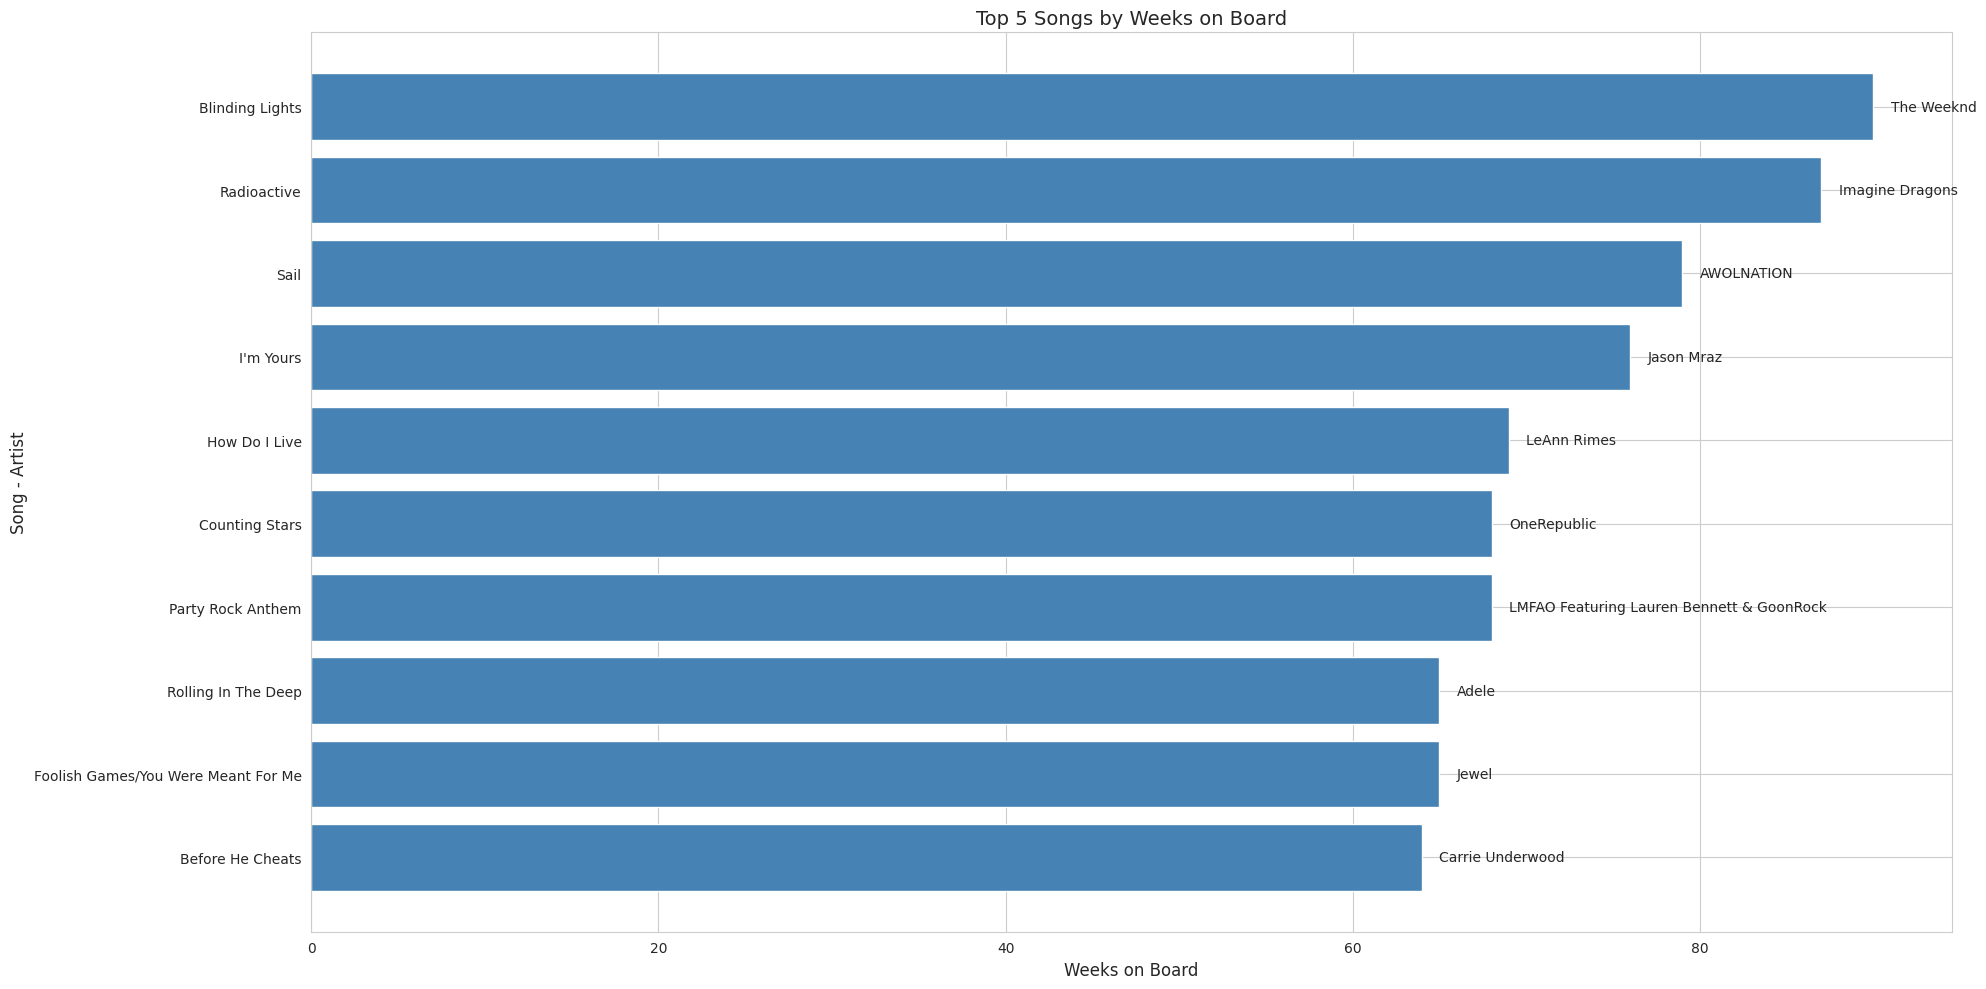

In [ ]:
df_unique = billboard_tracks.groupby('song').agg({'artist': 'first', 'weeks-on-board': 'max'}).reset_index()

# Sort by weeks-on-board and select top 10
df_top10 = df_unique.sort_values('weeks-on-board', ascending=False).head(10)

# Create the plot
fig, ax = plt.subplots(figsize=(20, 10))
ax.barh(df_top10['song'], df_top10['weeks-on-board'], color='steelblue')

# Set the title and labels
ax.set_title('Top 5 Songs by Weeks on Board', fontsize=14)
ax.set_xlabel('Weeks on Board', fontsize=12)
ax.set_ylabel('Song - Artist', fontsize=12)

# Add artist name to each bar
for i, (song, artist) in enumerate(zip(df_top10['song'], df_top10['artist'])):
    ax.text(df_top10.loc[df_top10['song']==song, 'weeks-on-board'].values[0]+1, i, artist, ha='left', va='center', fontsize=10)

ax.invert_yaxis()

plt.tight_layout()

plt.show()


### Most Successful Artists

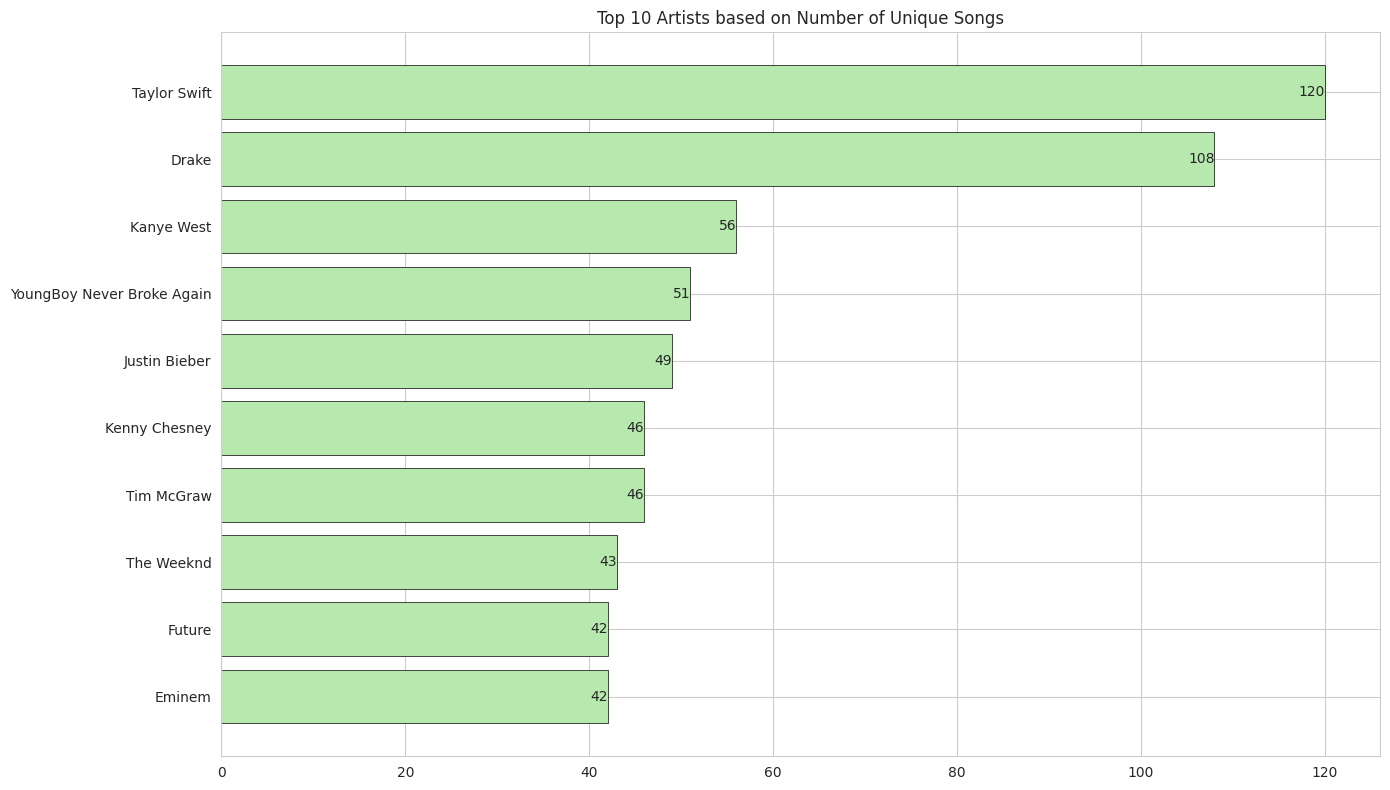

In [ ]:
artist_counts = billboard_tracks.groupby('artist')['song'].nunique().sort_values(ascending=False)

# removing "Glee Cast" from the results (highest) since they are not a singular artist
top_10_artists = artist_counts.head(11)[1:]

# Set the figure size
plt.figure(figsize=(14, 8))

# Create a horizontal bar plot for the top 10 artists
bar_colors = '#b7e9af'  # Light green color
border_color = 'black'  # Black border color
border_width = 0.5      # Thin border width

bars = plt.barh(top_10_artists.index[::-1], top_10_artists.values[::-1], color=bar_colors, edgecolor=border_color, linewidth=border_width)

for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{int(width)}', ha='right', va='center')

# Set the labels and title
plt.title('Top 10 Artists based on Number of Unique Songs')

# Adjust spacing between subplots and remove unnecessary borders
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
# remove all fields other than song, rank, and artist
billboard_tracks.drop(columns = ['date', 'last-week', 'peak-rank', 'weeks-on-board', 'release_date'], inplace=True)

# ensure that song name and artist is a string
billboard_tracks['song'] = billboard_tracks['song'].astype(str)
billboard_tracks['artist'] = billboard_tracks['artist'].astype(str)

# remove all non alphanumeric characters in song name and artist
billboard_tracks['song'] = billboard_tracks['song'].replace(r'[^A-Za-z0-9\s]+', '', regex=True)
billboard_tracks['artist'] = billboard_tracks['artist'].replace(r'[^A-Za-z0-9\s]+', '', regex=True)

# remove extra spaces in song name and artist
billboard_tracks['song'] = billboard_tracks['song'].replace(r'\s\s+', ' ', regex=True)
billboard_tracks['artist'] = billboard_tracks['artist'].replace(r'\s\s+', ' ', regex=True)

# remove all special characters, including punctuation
billboard_tracks['song'] = billboard_tracks['song'].replace(r'[^\w\s]|_', '', regex=True)
billboard_tracks['artist'] = billboard_tracks['artist'].replace(r'[^\w\s]|_', '', regex=True)

# make all characters in song name lowercase
billboard_tracks['song'] = billboard_tracks.song.apply(lambda x: x.lower())
billboard_tracks['artist'] = billboard_tracks.artist.apply(lambda x: x.lower())

# length of billboard_tracks
len(billboard_tracks)

166200

## Joining the two datasets

### Distribution of Data

<ipython-input-18-ead2890e5a1a>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


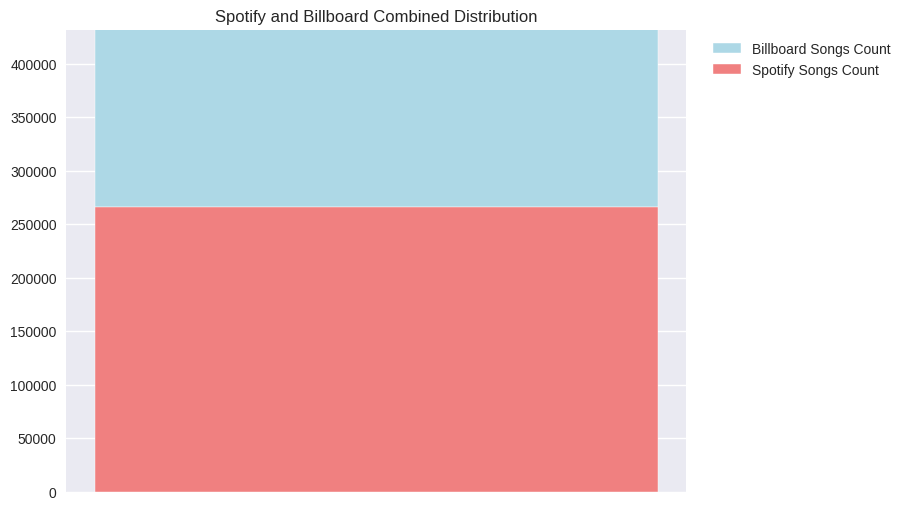

In [ ]:
sp_count = len(spotify_tracks)
bill_count = len(billboard_tracks)
total = bill_count + sp_count

plt.figure(figsize=(8, 6))
plt.style.use('seaborn')

# Define the colors for the bars
colors = ['lightcoral', 'lightblue']

# Create a bar plot with different colors
plt.bar(0, bill_count, bottom=sp_count, color=colors[1], label='Billboard Songs Count')
plt.bar(0, sp_count, color=colors[0], label='Spotify Songs Count')

# Set the total height of the bar
plt.ylim(0, total)

plt.title('Spotify and Billboard Combined Distribution')
# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1))
plt.xticks([])

# Display the plot
plt.show()

In [ ]:
# ensure that columns we join on are the same
spotify_tracks.rename(columns={'artists': 'artist', 'name': 'song'}, inplace=True)
print("Number of songs in Spotify data:", len(spotify_tracks))
print("Number of songs in Billboard data:", len(billboard_tracks))

# perform left join
combined_tracks = spotify_tracks.merge(billboard_tracks, how = 'left', on = ['song', 'artist'])

# replace nan values with zero, if there is no matches from the merge
combined_tracks['rank'] = combined_tracks['rank'].replace(np.nan, 0)

# convert the rank into binary variable (1 if popular, 0 otherwise)
combined_tracks['billboard_popularity'] = np.where(combined_tracks['rank'] > 0, 1, 0)

# drop the billboard rank, since we don't want it infuencing our prediction
combined_tracks.drop(columns = ['rank'], inplace=True)

print("Number of songs in combined data:", len(combined_tracks))

Number of songs in Spotify data: 265669
Number of songs in Billboard data: 166200
Number of songs in combined data: 347124


## Checking and Removing Duplicate Song Entries

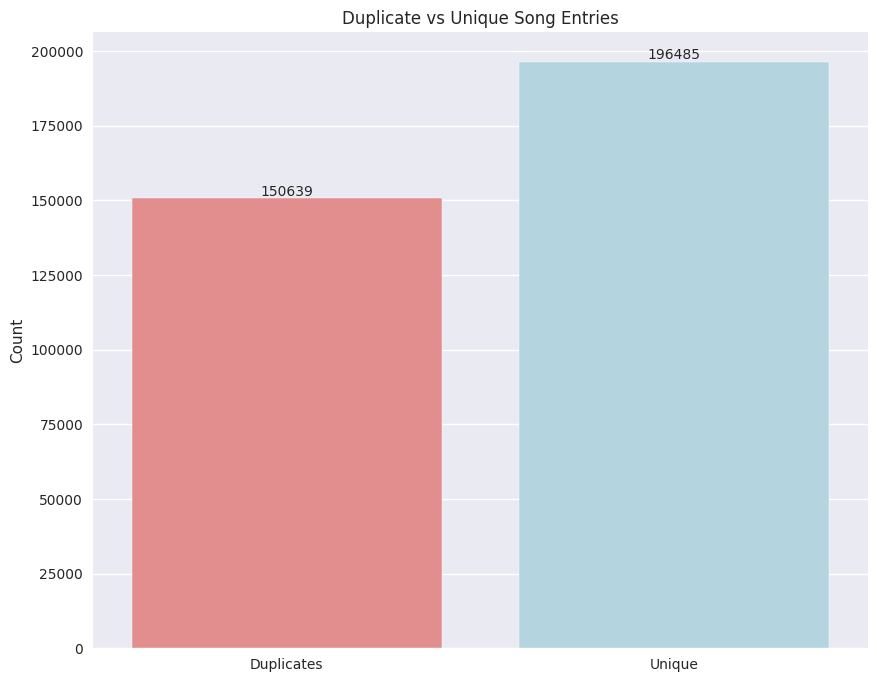

In [ ]:
duplicate_counts = combined_tracks['song'].duplicated().sum()
non_duplicate_counts = len(combined_tracks['song'].unique())
fig, ax = plt.subplots(figsize=(10, 8))
sns.set_style("whitegrid")
sns.barplot(x=['Duplicates', 'Unique'], y=[duplicate_counts, non_duplicate_counts], palette=['lightcoral', 'lightblue'], ax=ax)
ax.set_title('Duplicate vs Unique Song Entries')
ax.set_ylabel('Count')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

In [ ]:
# songs and the number of times they appear in the dataframe
song_counts = combined_tracks['song'].value_counts()

# get songs that appear more than once in the dataframe
song_counts_gt_1 = song_counts[song_counts > 1]

# sum of the number of times duplicate songs appear in the dataframe
total_count = song_counts_gt_1.sum()

# number of duplicates in the dataframe
duplicates = (song_counts > 1).sum()

print("Number of songs that have duplicate entries:", duplicates)
print(f"Number of duplicate entries: {total_count - duplicates} out of {len(combined_tracks)}")

combined_tracks = combined_tracks.drop_duplicates(subset=['song'])
print("The total number of combined tracks, after removing duplicates, is", len(combined_tracks)) 

Number of songs that have duplicate entries: 22336
Number of duplicate entries: 150639 out of 347124
The total number of combined tracks, after removing duplicates, is 196485


### Spotify Popularity vs Billboard Popularity

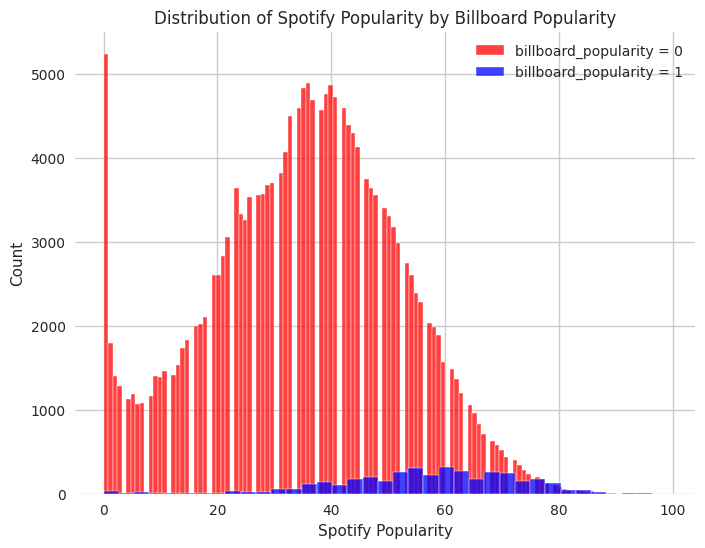

In [ ]:
# Filter the dataframe for billboard_popularity = 0
popularity_0 = combined_tracks.loc[combined_tracks['billboard_popularity'] == 0, 'popularity']

# Filter the dataframe for billboard_popularity = 1
popularity_1 = combined_tracks.loc[combined_tracks['billboard_popularity'] == 1, 'popularity']

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))
sns.set_style("whitegrid")

# Plot the values for billboard_popularity = 0
sns.histplot(popularity_0, color='red', label='billboard_popularity = 0', ax=ax)

# Plot the values for billboard_popularity = 1
sns.histplot(popularity_1, color='blue', label='billboard_popularity = 1', ax=ax)

# Set the title and labels
ax.set_title('Distribution of Spotify Popularity by Billboard Popularity')
ax.set_xlabel('Spotify Popularity')
ax.set_ylabel('Count')

# Show the legend
plt.legend()

# Show the plot
plt.show()

## Create separate dataset with song names vectorized

In [ ]:
import dask.dataframe as dd

# perform count vectorizer (goal is to see if song name has impact on popularity)

count_vect = TfidfVectorizer(binary=False, min_df=150)
#print("init TF idf vectorizer")
name_vectorized = count_vect.fit_transform(combined_tracks['song'])

combined_vectsongs = combined_tracks.copy()

count_vect_df = pd.DataFrame(name_vectorized.todense(), columns = count_vect.get_feature_names_out())

# alternative way of dropping index column
combined_vectsongs.reset_index(drop=True, inplace=True)
print("shape of combined_vectsongs: ")
print(combined_vectsongs.shape)

#count_vect_df = count_vect_df.reset_index().drop('index', axis = 1)
count_vect_df.reset_index(drop=True, inplace=True)
print("shape of count_vect_df: ")
print(count_vect_df.shape)

combined_vectsongs = pd.concat([combined_vectsongs, count_vect_df], axis = 1)

shape of combined_vectsongs: 
(196485, 18)
shape of count_vect_df: 
(196485, 428)


## Creating two datasets, two where Spotify popularity is used as target, and the other two where Billboard popularity is used as target

In [ ]:
# create dataset where Spotify popularity is target
combined_spotify = combined_tracks.drop(columns = ['billboard_popularity'])
combined_spotify_vectsongs = combined_vectsongs.drop(columns = ['billboard_popularity'])

print("Number of songs in dataset: ", len(combined_spotify))

# create dataset where Billboard popularity is target
combined_billboard = combined_tracks.drop(columns = ['popularity'])
combined_billboard_vectsongs = combined_vectsongs.drop(columns = ['popularity'])

combined_billboard_vectsongs.columns

Number of songs in dataset:  196485


Index(['song', 'artist', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'mode', 'speechiness', 'instrumentalness',
       ...
       'world', 'ya', 'yang', 'year', 'years', 'yo', 'you', 'young', 'your',
       'youre'],
      dtype='object', length=445)

## Random Undersampling to Balance Billboard class data

### Class Imbalance

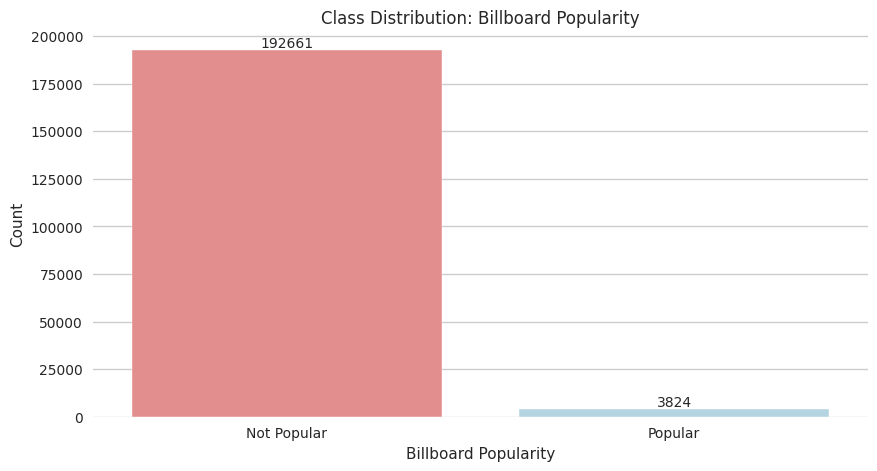

In [ ]:
class_counts = combined_tracks['billboard_popularity'].value_counts()

fig, ax = plt.subplots(figsize=(10, 5))
sns.set_style("whitegrid")
sns.barplot(x=class_counts.index, y=class_counts.values, palette=['lightcoral', 'lightblue'], ax=ax)

ax.set_title('Class Distribution: Billboard Popularity')
ax.set_xlabel('Billboard Popularity')
ax.set_ylabel('Count')
ax.set_xticklabels(['Not Popular', 'Popular'])

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

In [ ]:
# count # of songs in billboard dataset that are popular
df_billboard_popular = combined_billboard[combined_billboard['billboard_popularity'] == 1]
print("Number of songs in billboard dataset that are popular: ", len(df_billboard_popular))
df_billboard_unpopular = combined_billboard[combined_billboard['billboard_popularity'] == 0]
print("Number of songs in billboard dataset that are unpopular: ", len(df_billboard_unpopular))

# count # of songs in combined_billboard_vectsongs dataset that are popular
df_billboard_popular_vectsongs = combined_billboard_vectsongs[combined_billboard_vectsongs['billboard_popularity'] == 1]
print("Number of songs in combined_billboard_vectsongs dataset that are popular: ", len(df_billboard_popular_vectsongs))
df_billboard_unpopular_vectsongs = combined_billboard_vectsongs[combined_billboard_vectsongs['billboard_popularity'] == 0]
print("Number of songs in combined_billboard_vectsongs dataset that are unpopular: ", len(df_billboard_unpopular_vectsongs))

Number of songs in billboard dataset that are popular:  3824
Number of songs in billboard dataset that are unpopular:  192661
Number of songs in combined_billboard_vectsongs dataset that are popular:  3824
Number of songs in combined_billboard_vectsongs dataset that are unpopular:  192661


In [ ]:
# randomly sample 3824 songs from unpopular dataset
df_billboard_unpopular_sample = df_billboard_unpopular.sample(n=3824, random_state=1)

# combine back the unpopular sample and popular dataset, and shuffle the rows
combined_billboard = pd.concat([df_billboard_popular, df_billboard_unpopular_sample])

# randomly sample 3824 songs from df_billboard_unpopular_vectsongs dataset
df_billboard_unpopular_sample_vectsongs = df_billboard_unpopular_vectsongs.sample(n=3824, random_state=1)

# combine back the unpopular sample and popular dataset, and shuffle the rows
combined_billboard_vectsongs = pd.concat([df_billboard_popular_vectsongs, df_billboard_unpopular_sample_vectsongs])

### Dropping song and artist names

In [ ]:
# For fetching lyrics later, we will need artist and song name
genius_tracks = combined_billboard.copy()
genius_tracks_vectorized = combined_billboard_vectsongs.copy()

combined_billboard.drop(columns = ['song'], inplace=True)
combined_billboard.drop(columns=['artist'], inplace=True)

combined_billboard_vectsongs.drop(columns = ['song'], inplace=True)
combined_billboard_vectsongs.drop(columns=['artist'], inplace=True)

combined_spotify.drop(columns = ['song'], inplace=True)
combined_spotify.drop(columns=['artist'], inplace=True)

combined_spotify_vectsongs.drop(columns = ['song'], inplace=True)
combined_spotify_vectsongs.drop(columns=['artist'], inplace=True)

## Transfer Learning

In [ ]:
!pip install transformers==4.28.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.3 MB/s eta 0:00:00


In [ ]:
!pip3 install Cython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from transformers import BertForSequenceClassification, BertTokenizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup

# Split the data into training and test sets
df_train, df_test = train_test_split(combined_billboard_vectsongs, test_size=0.2, random_state=42)

# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Prepare data for training
train_labels = df_train['billboard_popularity'].values
train_encodings = tokenizer(list(df_train.index.astype(str)), truncation=True, padding=True, max_length=512)
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_encodings['input_ids']),
                                               torch.tensor(train_labels))

test_labels = df_test['billboard_popularity'].values
test_encodings = tokenizer(list(df_test.index.astype(str)), truncation=True, padding=True, max_length=512)
test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_encodings['input_ids']),
                                              torch.tensor(test_labels))

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=16, sampler=RandomSampler(train_dataset))
test_loader = DataLoader(test_dataset, batch_size=16, sampler=SequentialSampler(test_dataset))

# Fine-tune the BERT model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

num_epochs = 5
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, labels = batch[0].to(device), batch[1].to(device)
        outputs = model(input_ids, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss}')

# Evaluate the fine-tuned model
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, labels = batch[0].to(device), batch[1].to(device)
        outputs = model(input_ids)
        logits = outputs.logits
        pred_labels = logits.argmax(dim=1)
        predictions.extend(pred_labels.cpu().numpy())

f1_test = f1_score(test_labels, predictions, average='micro')
print(f"F1-Score on the test set: {f1_test}")

# Save the fine-tuned model
torch.save(model.state_dict(), 'fine_tuned_bert_model.pth')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 1/5, Loss: 0.6004022500689284
Epoch 2/5, Loss: 0.5104748970845971
Epoch 3/5, Loss: 0.472765415712374
Epoch 4/5, Loss: 0.44665193553848614
Epoch 5/5, Loss: 0.41997833621953234
F1-Score on the test set: 0.8071895424836601
